# Exercise 5.1 

## Import Libraries
Python requires importing libraries and functions you need to access specific tools like science (scipy), linear algebra (numpy), and graphics (matplotlib). These libraries can be installed using the ```pip``` command line tool. Alternatively you can install an python distribution like [Anaconda](https://www.continuum.io/downloads) or [Canopy](https://www.enthought.com/products/canopy/)  which have these and many other standard package pre-installed.

In [1]:
import ipywidgets as widgets  # add new widgets
from ipywidgets import interact, interactive, fixed
import os
from IPython.display import display
import numpy as np  # linear algebra / matrices
from skimage.color import label2rgb
from sklearn.metrics import roc_curve, auc  # roc curve tools
from skimage.segmentation import mark_boundaries  # mark labels
from skimage.io import imread  # read in images
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
# make the notebook interactive

In [2]:
base_path = '04-files'
seg_path = os.path.join(base_path, 'DogVsMuffin_seg_bw.jpg')
rgb_path = os.path.join(base_path, 'DogVsMuffin.jpg')
face_path = os.path.join(base_path, 'DogVsMuffin_face.jpg')
seg_img = imread(seg_path)[80:520:2, :450:2]
rgb_img = imread(rgb_path)[80:520:2, :450:2, :]
face_img = imread(face_path)
print('RGB Size', rgb_img.shape, 'Seg Size',
      seg_img.shape, 'Face Size', face_img.shape)

RGB Size (220, 225, 3) Seg Size (220, 225) Face Size (111, 131, 3)


Text(0.5, 1.0, 'Labeled Image')

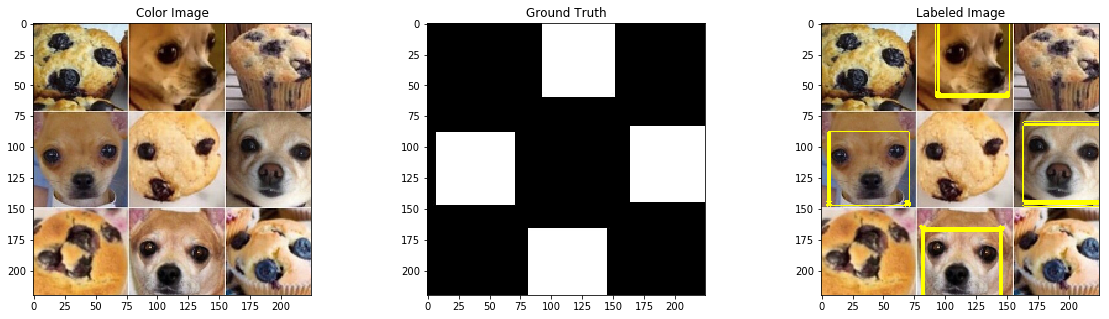

In [3]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, cmap='gray')  # show the segments
ax2.set_title("Ground Truth")
ax3.imshow(mark_boundaries(rgb_img, seg_img))
ax3.set_title("Labeled Image")

## Creating a Simple ROC Curve
We use the score function of taking the mean of the red green and blue channels
$$ I = \frac{R+G+B}{3} $$
We then take the score by normalizing by the maximum value (since the image is 8bit this is 255)
$$ s = \frac{I}{255} $$

In [4]:
ground_truth_labels = seg_img.flatten() > 0
score_value = 1-np.mean(rgb_img.astype(np.float32), 2).flatten()/255.0
fpr, tpr, _ = roc_curve(ground_truth_labels, score_value)
roc_auc = auc(fpr, tpr)

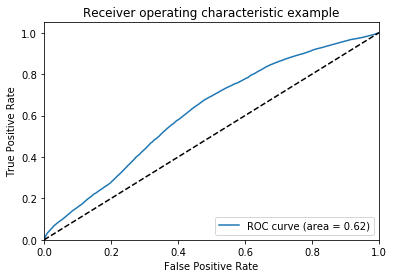

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Adding Filters
We can add a filter to this process by importing a ```uniform_filter``` and applying it before processing the image


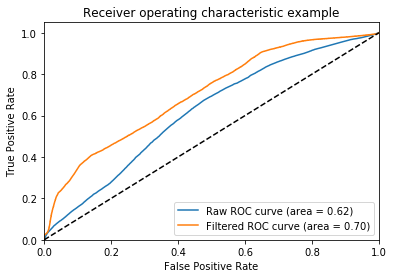

In [6]:
from scipy.ndimage.filters import uniform_filter
%matplotlib inline
filter_size = 45
filtered_image = uniform_filter(np.mean(rgb_img, 2), filter_size)
score_value = 1-filtered_image.astype(np.float32).flatten()/255.0
fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
roc_auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fpr2, tpr2, label='Filtered ROC curve (area = %0.2f)' % roc_auc2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

### Tasks
1. How can you improve filtering in this analysis? 
 - Which filter elements might improve the area under the ROC?
 - Try making workflows to test out a few different filters
2. Where might morphological operations fit in?
 - How can you make them part of this workflow as well?
3. (Challenge) Try and use the optimize toolbox of _scipy_ with the fmin function (```from scipy.optimize import fmin```) to find the optimum parmeters for the highers area (hint: fmin finds the minimum value)

In [7]:
from scipy.optimize import fmin


def calc_auc(rv, gv, bv, fsize):
    filter_size = 45
    gray_image = (rv*rgb_img[:, :, 0]+gv*rgb_img[:, :,
                                                 1]+bv*rgb_img[:, :, 2])/(rv+gv+bv)
    filtered_image = uniform_filter(gray_image, filter_size)
    score_value = filtered_image.astype(np.float32).flatten()/255.0
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': gray_image, 'fimg': filtered_image}

In [8]:
# test the function to make sure it works
def min_func(args): return 1-calc_auc(*args)['auc']


min_start = [1, 1, 1, 20]
min_func(min_start)

0.5816832780671142

In [9]:
opt_res = fmin(min_func, min_start)

Optimization terminated successfully.
         Current function value: 0.326574
         Iterations: 343
         Function evaluations: 716


In [10]:
opt_values = calc_auc(*opt_res)
tprOpt = opt_values['tpr']
fprOpt = opt_values['fpr']
roc_aucOpt = opt_values['auc']

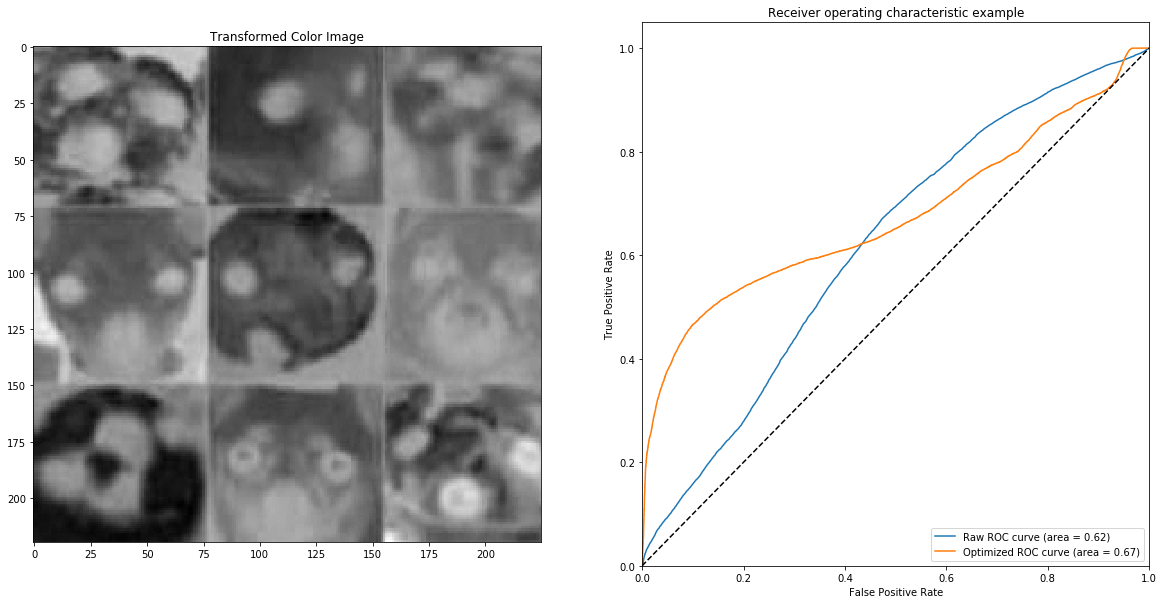

In [11]:
fig, (ax_img, ax) = plt.subplots(1, 2, figsize=(20, 10))
ax_img.imshow(opt_values['gimg'], cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Non-linear optimization
Here we use non-linear approaches to improve the quality of the results

In [12]:
def relu(x):
    return (x+np.abs(x))/2


def calc_auc_nl(rv, rm, gv, gm, bv, bm):
    filter_size = 45
    gray_image = (rv*relu(rgb_img[:, :, 0]/255.0-rm)+gv*relu(rgb_img[:, :, 1]/255.0-gm) +
                  bv*relu(rgb_img[:, :, 2]/255.0-bm))/(rv+gv+bv)
    score_value = gray_image.astype(np.float32).flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': gray_image, 'fimg': filtered_image}

In [13]:
# test the function to make sure it works
def min_func(args): return 1-calc_auc_nl(*args)['auc']


min_start = [1, 0, 1, 0, 1, 0]
min_start[0] = opt_res[0]
min_start[2] = opt_res[1]
min_start[4] = opt_res[2]
min_func(min_start)

0.3846391595171852

In [14]:
opt_res = fmin(min_func, min_start, maxiter=100)

In [15]:
opt_values_nl = calc_auc_nl(*opt_res)
tprOpt_nl = opt_values_nl['tpr']
fprOpt_nl = opt_values_nl['fpr']
roc_aucOpt_nl = opt_values_nl['auc']

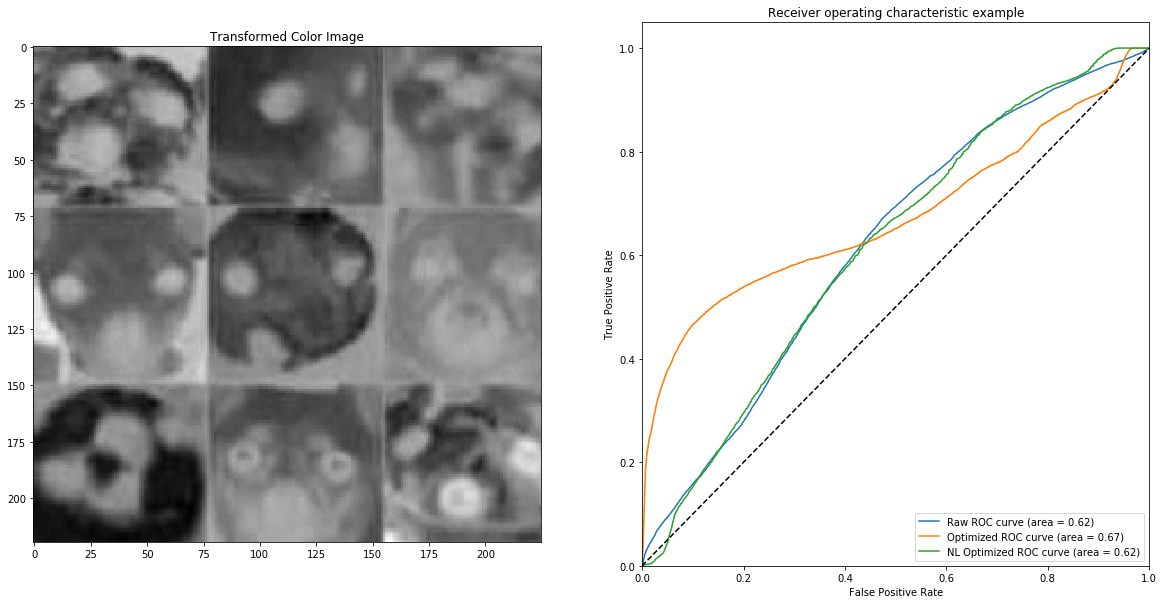

In [16]:
fig, (ax_img, ax) = plt.subplots(1, 2, figsize=(20, 10))
ax_img.imshow(opt_values_nl['gimg'], cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_nl, tprOpt_nl,
        label='NL Optimized ROC curve (area = %0.2f)' % roc_aucOpt_nl)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

# Next Steps
Rather than simply adjusting basic parameters, we can adjust entire arrays of information. The example below is the a convolutional neural network with one two layers

In [17]:
from scipy.signal import fftconvolve

def convolve(img1, img2): return fftconvolve(img1, img2, mode='same')


CONV_SIZE = (10, 10, 1)
grey_img = np.reshape(np.mean(rgb_img, 2)/255.0,
                      (rgb_img.shape[0], rgb_img.shape[1], 1))

def calc_auc_conv(rcoefs):
    coefs = rcoefs.reshape(CONV_SIZE)/rcoefs.sum()
    score_image = relu(convolve(grey_img, coefs))
    score_value = score_image.flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': score_image}

## Make a nice gaussian kernel


In [18]:
np.random.seed(2019)
from functools import reduce
def gkern_nd(d=2, kernlen=21, nsigs=3, min_smooth_val=1e-2):
    nsigs = [nsigs] * d
    k_wid = (kernlen - 1) / 2
    all_axs = [np.linspace(-k_wid, k_wid, kernlen)] * d
    all_xxs = np.meshgrid(*all_axs)
    all_dist = reduce(np.add, [
        np.square(cur_xx) / (2 * np.square(np.clip(nsig, min_smooth_val,
                                                   kernlen)))
        for cur_xx, nsig in zip(all_xxs, nsigs)])
    kernel_raw = np.exp(-all_dist)
    return kernel_raw / kernel_raw.sum()

In [19]:
# test the function to make sure it works
def min_func(rcoefs): return 1-calc_auc_conv(rcoefs)['auc']

min_start = gkern_nd(2, CONV_SIZE[0]).ravel()
min_func(min_start)

0.6342541805892854

In [20]:
opt_res_conv = min_start
opt_res_conv = fmin(min_func,
                    opt_res_conv,
                    maxiter=500)

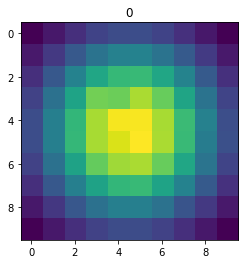

In [21]:
opt_values_conv = calc_auc_conv(opt_res_conv)
tprOpt_conv = opt_values_conv['tpr']
fprOpt_conv = opt_values_conv['fpr']
roc_aucOpt_conv = opt_values_conv['auc']
out_kernel = opt_res_conv.reshape(CONV_SIZE)/opt_res_conv.sum()
fig, ax_all = plt.subplots(1, out_kernel.shape[2])
for i, c_ax in enumerate(np.array(ax_all).flatten()):
    c_ax.imshow(out_kernel[:, :, i])
    c_ax.set_title(str(i))

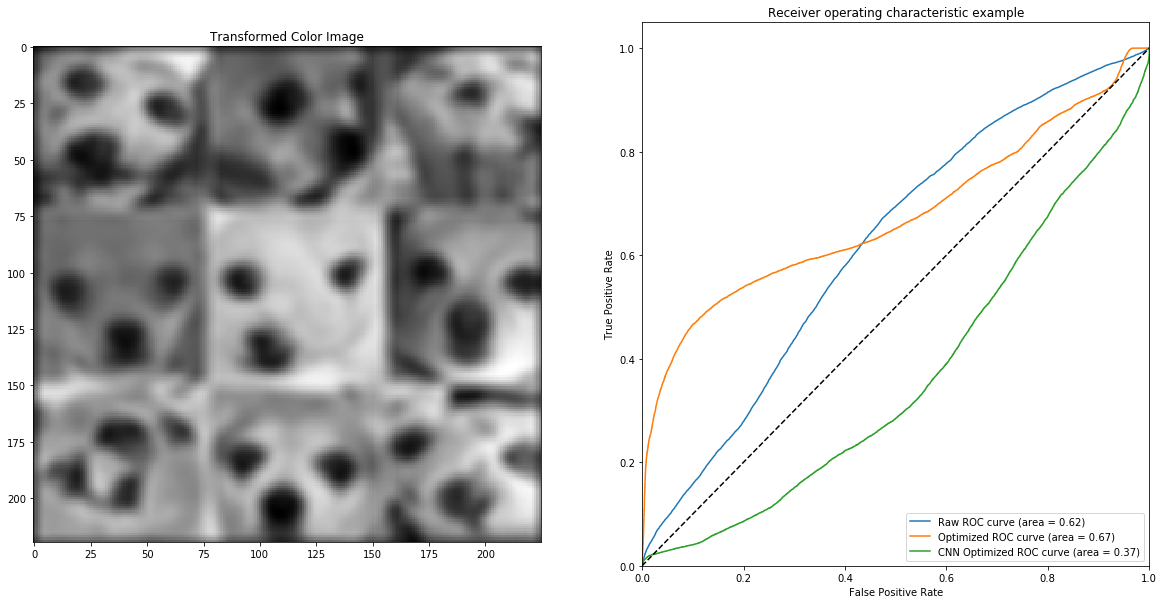

In [22]:
fig, (ax_img, ax) = plt.subplots(1, 2, figsize=(20, 10))
ax_img.imshow(opt_values_conv['gimg'].squeeze(), cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_conv, tprOpt_conv,
        label='CNN Optimized ROC curve (area = %0.2f)' % roc_aucOpt_conv)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## RGB CNN
Using the RGB instead of the gray value for the CNN

In [23]:
CONV_SIZE = (10, 10, 3)

def calc_auc_conv2d(rcoefs):
    coefs = rcoefs.reshape(CONV_SIZE)/rcoefs.sum()
    score_image = relu(convolve(grey_img, coefs))
    score_value = score_image.flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': score_image}

In [24]:
def min_func(rcoefs): return 1-calc_auc_conv2d(rcoefs)['auc']
min_kernel = np.stack([gkern_nd(2, kernlen=CONV_SIZE[0])]*3, -1)
min_start = min_kernel.ravel()
for i in range(10):
    min_func(min_start)

In [27]:
opt_res_conv2d = fmin(min_func, min_start, maxfun=50, maxiter=100)

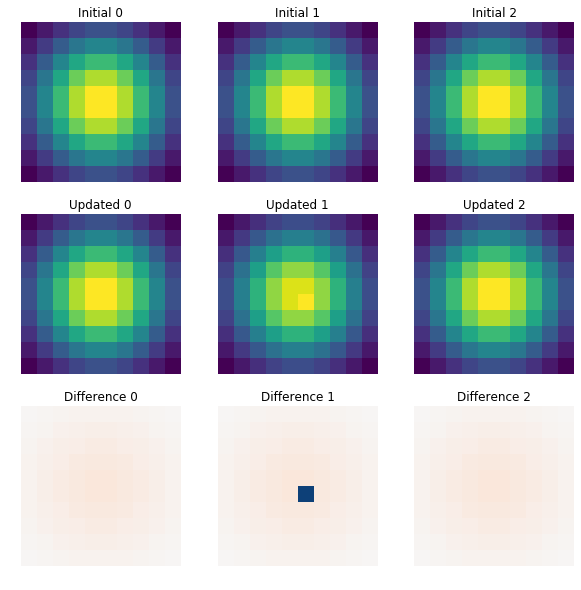

In [28]:
opt_values_conv = calc_auc_conv2d(opt_res_conv2d)
tprOpt_conv = opt_values_conv['tpr']
fprOpt_conv = opt_values_conv['fpr']
roc_aucOpt_conv = opt_values_conv['auc']
out_kernel = opt_res_conv2d.reshape(CONV_SIZE)/opt_res_conv.sum()
fig, ax_all = plt.subplots(3, out_kernel.shape[2], figsize=(10, 10))
for i, (c_ax, d_ax, cd_ax) in enumerate(ax_all.T):
    c_ax.imshow(min_kernel[:, :, i])
    c_ax.set_title('Initial {}'.format(i))
    c_ax.axis('off')
    d_ax.imshow(out_kernel[:, :, i])
    d_ax.set_title('Updated {}'.format(i))
    d_ax.axis('off')
    cd_ax.imshow(out_kernel[:, :, i]-min_kernel[:, :, i],
               cmap='RdBu', vmin=-1e-3, vmax=1e-3)
    cd_ax.set_title('Difference {}'.format(i))
    cd_ax.axis('off')

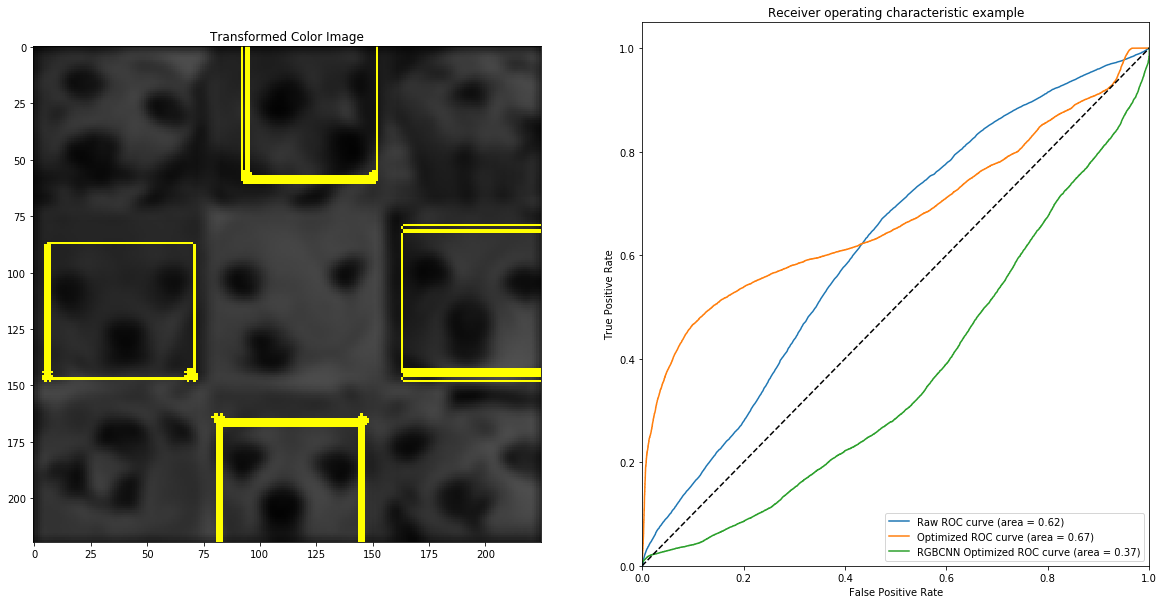

In [29]:
fig, (ax_img, ax) = plt.subplots(1, 2, figsize=(20, 10))
ax_img.imshow(mark_boundaries(
    opt_values_conv['gimg'].squeeze(), seg_img), cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_conv, tprOpt_conv,
        label='RGBCNN Optimized ROC curve (area = %0.2f)' % roc_aucOpt_conv)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

### Tasks
1. How can you improve filtering in this analysis? 
 - Which filter elements might improve the area under the ROC?
 - Try making workflows to test out a few different filters
2. Where might morphological operations fit in?
 - How can you make them part of this workflow as well?
3. (Challenge) How would you add multiple filter operations? Can you optimize all of the parameters? What problems do you run into as you make your model more complex?